# Life Cycle Model with Numba
#### Kazuharu Yanagimoto

In [1]:
import datetime; datetime.datetime.now().strftime('%B %-d, %Y')

'January 7, 2022'

In [2]:
import numpy as np
from numba import njit, int64, float64, prange, get_num_threads
from numba.experimental import jitclass
from quantecon.markov.approximation import tauchen
from matplotlib import pyplot as plt

## Model
This note examines the model of [Parallel Computing](https://github.com/davidzarruk/Parallel_Computing/).

For $t = 1, \dots, T$, households solve

$$\begin{aligned}
V(t, e, x) =& \max_{c, x'} \frac{c^{1 - \sigma}}{1 - \sigma} + \beta \mathbb{E}V(t + 1, e', x') \\
&\text{s.t. } \\
& c + x' \le (1 + r)x + ew \\
& \text{Pr}(e' | e) = \Gamma(e) \\
& x' \ge 0
\end{aligned}$$

In [3]:
# Grid for x
n_x = 1500
x_min = 0.1
x_max = 4.0
x_grid = np.linspace(x_min, x_max, num=n_x, dtype=np.float64)

# Grid for e
n_e = 15
ssigma_eps = 0.02058
lambda_eps = 0.99
m = 1.5
mc = tauchen(lambda_eps, ssigma_eps, 0.0, m, n_e)
e_grid, P = np.exp(mc.state_values), mc.P

# Utility function
ssigma = 2.0
bbeta = 0.97
T = 10

# Prices
r = 0.07
w = 5.0

In [4]:
specs = [
        ('n_x', int64),
        ('x_grid', float64[:]),
        ('n_e', int64),
        ('e_grid', float64[:]),
        ('P', float64[:, :]),
        ('ssigma', float64),
        ('bbeta', float64),
        ('T', int64),
        ('r', float64),
        ('w', float64)
]

In [5]:
@jitclass(specs)
class States(object):
    def __init__(self,
                 n_x = n_x,
                 x_grid = x_grid,
                 n_e = n_e,
                 e_grid = e_grid,
                 P = P,
                 ssigma = ssigma,
                 bbeta = bbeta,
                 T = T,
                 r = r,
                 w = w):

        self.n_x = n_x
        self.n_e = n_e

        # Grid for x
        self.x_grid = x_grid

        # Grid for e
        
        self.e_grid, self.P = e_grid, P

        # Utility function
        self.ssigma = ssigma
        self.bbeta = bbeta
        self.T = T

        # Prices
        self.r = r
        self.w = w

In [6]:
@njit
def solve_single(states:States):

    n_x = states.n_x
    n_e = states.n_e
    x_grid = states.x_grid
    e_grid = states.e_grid
    P = states.P
    ssigma = states.ssigma
    bbeta = states.bbeta
    T = states.T
    r = states.r
    w = states.w

    V = np.zeros((n_x, n_e, T), dtype=np.float64)

    for t in range(T-1, -1, -1):
        for ix in range(n_x):
            for ie in range(n_e):

                utility = -np.inf
                for ixp in range(n_x):

                    expected = np.float64(0)
                    if t < (T-1):
                        for iep in range(n_e):
                            expected += P[ie, iep] * V[ixp, iep, t+1]

                    c = (1 + r) * x_grid[ix] + e_grid[ie] * w - x_grid[ixp]

                    if c > 0:
                        utility = max((c ** (1 - ssigma)) / (1 - ssigma) + bbeta * expected, utility)

                V[ix, ie, t] = utility
    
    return V

In [7]:
@njit(parallel=True)
def solve_threads(states:States):

    n_x = states.n_x
    n_e = states.n_e
    x_grid = states.x_grid
    e_grid = states.e_grid
    P = states.P
    ssigma = states.ssigma
    bbeta = states.bbeta
    T = states.T
    r = states.r
    w = states.w

    V = np.zeros((n_x, n_e, T), dtype=np.float64)

    for t in range(T-1, -1, -1):
        for i in prange(n_x * n_e):
            ix = i // n_e
            ie = i % n_e

            utility = -np.inf
            for ixp in range(n_x):

                expected = np.float64(0)
                if t < (T-1):
                    for iep in range(n_e):
                        expected += P[ie, iep] * V[ixp, iep, t+1]

                c = (1 + r) * x_grid[ix] + e_grid[ie] * w - x_grid[ixp]

                if c > 0:
                    utility = max((c ** (1 - ssigma)) / (1 - ssigma) + bbeta * expected, utility)

            V[ix, ie, t] = utility
    
    return V

## Test

In [8]:
states = States()

In [9]:
V = solve_single(states)

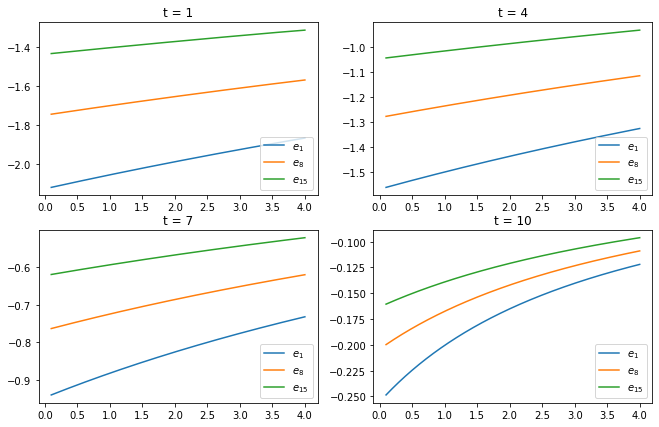

In [10]:
fig, axs = plt.subplots(2, 2, figsize = (11, 7))

for i in range(2):
  for j in range(2):
    t = [[0, 3], [6, 9]][i][j]
    axs[i, j].plot(states.x_grid, V[:, 0, t], label = r"$e_1$")
    axs[i, j].plot(states.x_grid, V[:, 7, t], label = r"$e_8$")
    axs[i, j].plot(states.x_grid, V[:, 14, t], label = r"$e_{15}$")
    axs[i, j].legend(loc = "lower right")
    axs[i, j].set_title(f"t = {t+1}")

plt.show()

In [11]:
 np.all(V == solve_threads(states)) # equivalence check

True

## Benchmark

In [12]:
%timeit V = solve_single(states)

9.95 s ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
get_num_threads() # Num of the phisical cores are the half

12

In [14]:
%timeit V = solve_threads(states)

1.38 s ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
